# <center>Battle of the Neighborhoods | Finding a Better Place in Toronto</center>

### 1. Importing Python libraries and Dependencies

In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2. Data Extraction and Cleaning

Using BeautifulSoup and Scraping List of Postal Codes of Given Wikipedia Page.
<br>Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracted_data = requests.get(url).text
soup = BeautifulSoup(extracted_data)

<br>Converting content of PostalCode HTML table as dataframe

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighbourhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest',
                                     'East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'
                                    }
                                   )

# Data Frame Below
print("Data Frame Shape: ",df.shape)
df.head()

Data Frame Shape:  (103, 3)


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


<br>Grouping the dataframe by Borough

In [4]:
df = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<br>Statistics for the DataFrame

In [5]:
df.describe()

,PostalCode,Borough,Neighbourhood
count,103,103,103
unique,103,15,103
top,M4P,North York,"Old Mill South, King's Mill Park, Sunnylea, Hu..."
freq,1,24,1


<br> Checking to see if any empty rows or unassigned cells in the DataFrame

In [6]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.PostalCode != empty ) & (df.Borough != empty) & (df.Neighbourhood != empty)]

In [7]:
df.value_counts().head()

PostalCode  Borough           Neighbourhood                      
M1B         Scarborough       Malvern, Rouge                         1
M5R         Central Toronto   The Annex, North Midtown, Yorkville    1
M6G         Downtown Toronto  Christie                               1
M6E         York              Caledonia-Fairbanks                    1
M6C         York              Humewood-Cedarvale                     1
dtype: int64

In [8]:
df.value_counts().tail()

PostalCode  Borough              Neighbourhood                                                                                              
M3L         North York           Downsview West                                                                                                 1
M3K         North York           Downsview East                                                                                                 1
M3J         North York           Northwood Park, York University                                                                                1
M3H         North York           Bathurst Manor, Wilson Heights, Downsview North                                                                1
M9W         Etobicoke Northwest  Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale    1
dtype: int64

In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighbourhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighbourhood')

In [10]:
df_2.describe()

,PostalCode,Borough,Neighbourhood
count,103,103,103
unique,103,15,103
top,M4P,North York,"Old Mill South, King's Mill Park, Sunnylea, Hu..."
freq,1,24,1


In [11]:
print(df_2.shape)
df_2.head()

(103, 3)


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<br> Defining a function for getting LAT and LONG values

In [12]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M1B')

[43.811390000000074, -79.19661999999994]

<br> Getting the coordinates for every Postal Code

In [13]:
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [14]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

<br> Checking if all coords were set into the DataFrame from the very first 5 row to the last 5

In [15]:
df_2.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [16]:
df_2.tail()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
98,M9N,York,Weston,43.70507,-79.51804
99,M9P,Etobicoke,Westmount,43.69630,-79.52926
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.68681,-79.55728
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.74453,-79.58624
102,M9W,Etobicoke Northwest,"Clairville, Humberwood, Woodbine Downs, West H...",43.71174,-79.57941


In [17]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.7729744, -79.2576479.


<br> Creating a map of Scarborough

In [18]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighbourhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [19]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood 1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood 1 are 43.7729744, -79.2576479.


### 3. Foursquare API

<br> Setting up the API for FourSquare

In [20]:
# @hidden_cell

CLIENT_ID = 'JHX542COZ1GUB3SZJGLMDY1TXRH1CYWU3PQXTO0IYKMTRF11' # your Foursquare ID
CLIENT_SECRET = 'FHD4AZ4NT0A2A0UQJBJEJW1T3TJQGDNBN2KJHJM0DFWLBE40' # your Foursquare Secret
VERSION = '20180604'

LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, latitude_x,longitude_y, radius, LIMIT)

# getting the venues data form Foursquare API in json format
results = requests.get(url).json()

In [21]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

<br> Defining a Function to get Category Types from the Extracted JSON Data

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<br> Cleaning the DataFrame Column "Categories" for the venues

In [23]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
2,lululemon athletica,Clothing Store,43.775517,-79.258423
3,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
4,Subway,Sandwich Place,43.775102,-79.257115


<br> Fetching the Top Ten Venue Categories in the Neighborhood

In [24]:
top_ten=pd.Series(nearby_venues.categories)
top_ten.value_counts()[:10]

Clothing Store      4
Jewelry Store       2
Pharmacy            2
Shoe Store          2
Coffee Shop         2
Department Store    2
Restaurant          2
Sandwich Place      2
Food Court          1
Bubble Tea Shop     1
Name: categories, dtype: int64

<br> Defining a Function to Retrieve Nearby Venues depending upon the Input of the Function
<br> Inputs being:
<li> 1. Name
<li> 2. Latitude
<li> 3. Longitude
<li> 4. Radius

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<br> Let's check the Function for Scarborough

In [26]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighbourhood'],
                                     latitudes=df_2['Latitude'],
                                     longitudes=df_2['Longitude'],
                                     )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


<br> Getting the Unique Venues, and their counts

In [27]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 252 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,14,14,14,14,14,14
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",2,2,2,2,2,2
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",18,18,18,18,18,18


### One-Hot Encoding the DataFrame

In [30]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]

Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Ma

<br> Getting the Top 5 Venues in the Scarborough Neighbourhood with the help of frequency count

In [31]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                  venue  freq
0  Hong Kong Restaurant  0.07
1       Badminton Court  0.07
2      Department Store  0.07
3        Discount Store  0.07
4             Newsagent  0.07


---- Alderwood, Long Branch ----
                   venue  freq
0      Convenience Store  0.25
1  Performing Arts Venue  0.25
2     Athletics & Sports  0.25
3                    Pub  0.25
4      Mobile Phone Shop  0.00


---- Bathurst Manor, Wilson Heights, Downsview North ----
                     venue  freq
0              Men's Store   0.5
1             Home Service   0.5
2  New American Restaurant   0.0
3            Metro Station   0.0
4       Mexican Restaurant   0.0


---- Bayview Village ----
                        venue  freq
0                       Trail  0.50
1  Construction & Landscaping  0.25
2                        Park  0.25
3          Mexican Restaurant  0.00
4   Middle Eastern Restaurant  0.00


---- Bedford Park, Lawrence Manor East ----
             venue  freq
0   Sa

<br> Defining a Function to return most common venues

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common Venues near every Neighborhood

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Hong Kong Restaurant,Badminton Court,Department Store,Discount Store,Newsagent,Chinese Restaurant,Shanghai Restaurant,Shopping Mall,Skating Rink,Supermarket
1,"Alderwood, Long Branch",Convenience Store,Performing Arts Venue,Athletics & Sports,Pub,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Newsagent,Miscellaneous Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Men's Store,Home Service,New American Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
3,Bayview Village,Trail,Construction & Landscaping,Park,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,New American Restaurant,Molecular Gastronomy Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Coffee Shop,Sports Club,Thai Restaurant,Pharmacy,Indian Restaurant,Butcher,Sushi Restaurant,Italian Restaurant,Cupcake Shop


### 4. K-Means Clustering Algorithm

In [34]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], dtype=int32)

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Scarborough_merged.head()# check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,1,Fast Food Restaurant,Furniture / Home Store,Yoga Studio,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,1,Home Service,Bar,Yoga Studio,New American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,0,Park,Construction & Landscaping,Gym / Fitness Center,Tea Room,Monument / Landmark,Museum,Moving Target,Movie Theater,Moroccan Restaurant,Yoga Studio
3,M1G,Scarborough,Woburn,43.76812,-79.21761,1,Coffee Shop,Korean BBQ Restaurant,Business Service,Park,Yoga Studio,Music Venue,Museum,Moving Target,Movie Theater,Moroccan Restaurant
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,1,Gaming Cafe,Trail,Yoga Studio,Music Venue,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant


### 5. Map of Clusters

In [42]:
kclusters = 10

In [43]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighbourhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [44]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

### Setting House Prices for the Neighborhoods

In [46]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighbourhood":df_2["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [48]:
Scarborough_Avg_HousingPrice.head()

,Neighbourhood,Average_Housing_Price
0,"Malvern, Rouge",335000.0
1,"Rouge Hill, Port Union, Highland Creek",286600.0
2,"Guildwood, Morningside, West Hill",175000.0
3,Woburn,225900.0
4,Cedarbrae,219400.0


In [49]:
Scarborough_Avg_HousingPrice.tail()

,Neighbourhood,Average_Housing_Price
98,Weston,370500.0
99,Westmount,255400.0
100,"Kingsview Village, St. Phillips, Martin Grove ...",413500.0
101,"South Steeles, Silverstone, Humbergate, Jamest...",433500.0
102,"Clairville, Humberwood, Woodbine Downs, West H...",254800.0


<br> 

### Setting the Neighborhood as Index for Visualization Purposes

In [50]:
Scarborough_Avg_HousingPrice.set_index('Neighbourhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighbourhood'>

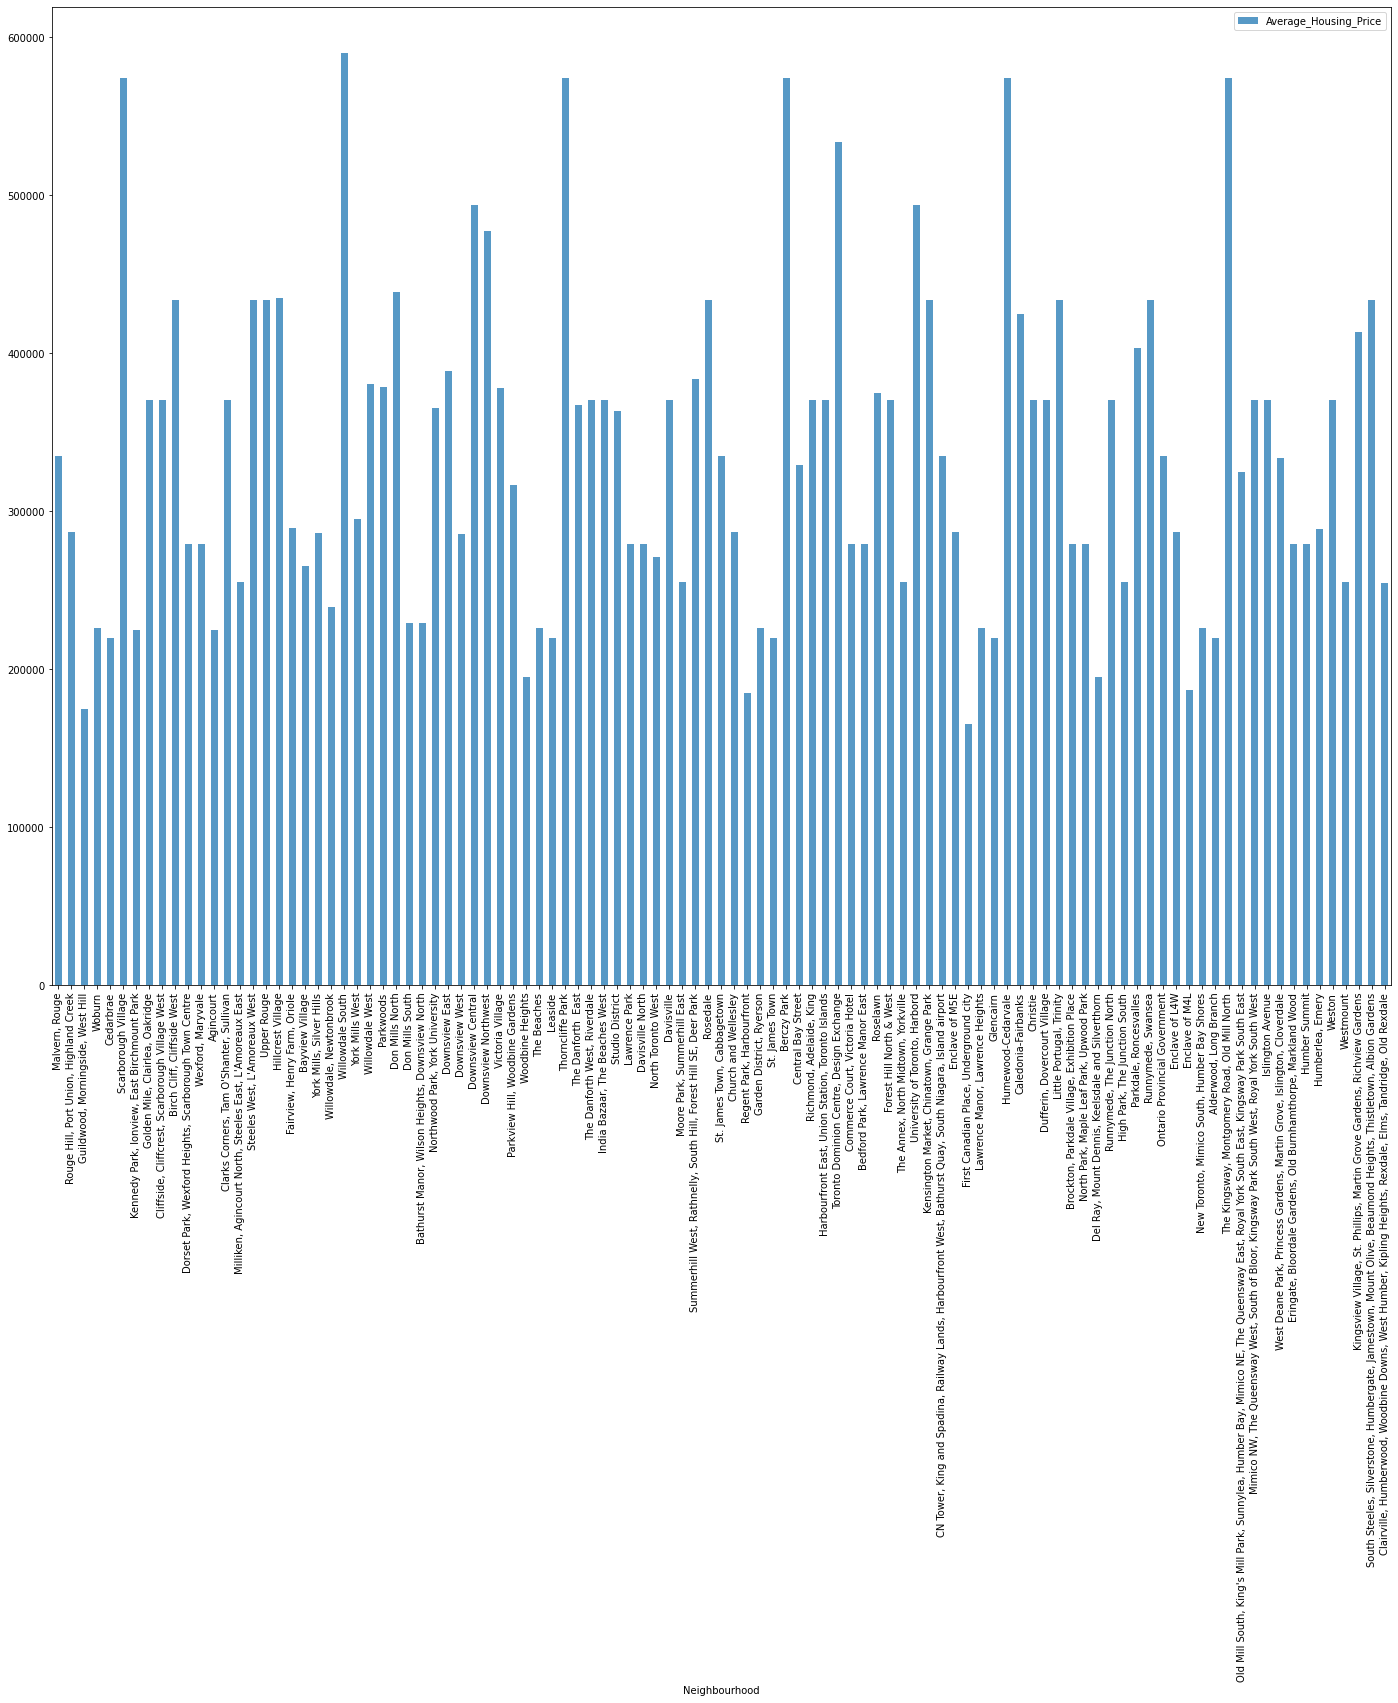

In [52]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [54]:
clusters=pd.DataFrame({"Cluster1":df1["Neighbourhood"],
                      "Cluster2":df2["Neighbourhood"],
                      "Cluster4":df3["Neighbourhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [55]:
new_Scarborough=Scarborough_merged.set_index("Neighbourhood",drop=True)

#Ratings Source: https://www.greatschools.org

Scarborough_school_ratings=pd.DataFrame({"Neighbourhood":df["Neighbourhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [56]:
Scarborough_school_ratings.head()

,Neighbourhood,Top School Rating
0,"Malvern, Rouge",7
1,"Rouge Hill, Port Union, Highland Creek",9
2,"Guildwood, Morningside, West Hill",5
3,Woburn,8
4,Cedarbrae,10


In [57]:
Scarborough_school_ratings.tail()

,Neighbourhood,Top School Rating
98,Weston,5
99,Westmount,6
100,"Kingsview Village, St. Phillips, Martin Grove ...",5
101,"South Steeles, Silverstone, Humbergate, Jamest...",8
102,"Clairville, Humberwood, Woodbine Downs, West H...",7


<br> 

### Setting the Neighborhood as Index for Visualization Purposes

In [59]:
Scarborough_school_ratings.set_index('Neighbourhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighbourhood'>

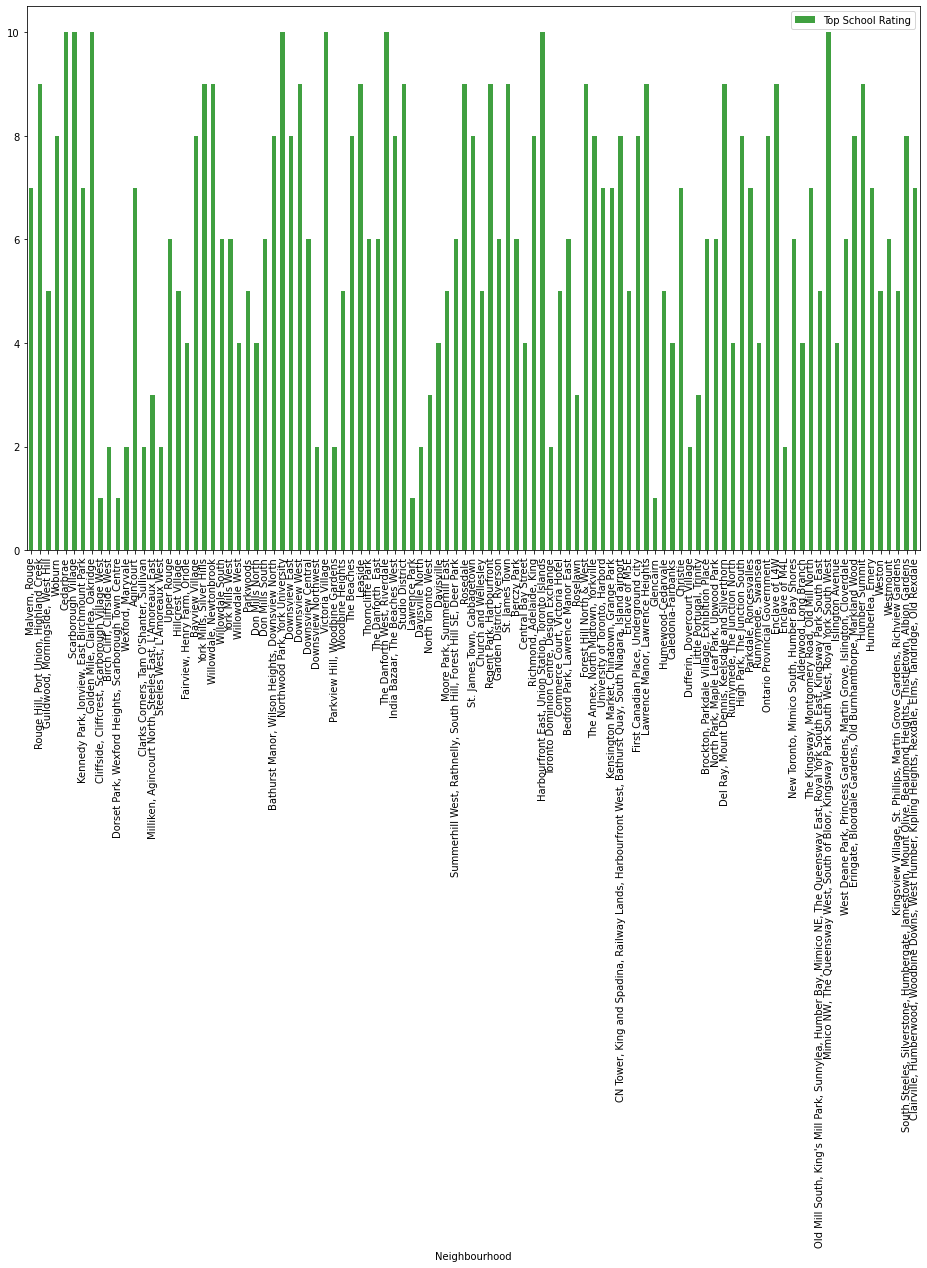

In [60]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75)

### Sorting the Values to find Top 5 Cheapest/Expensive Neighborhoods

In [64]:
Avg_House_Price_Sorted = Scarborough_Avg_HousingPrice.sort_values(by=['Average_Housing_Price'])
Avg_House_Price_Sorted.head()

,Average_Housing_Price
Neighbourhood,
"First Canadian Place, Underground city",165000.0
"Guildwood, Morningside, West Hill",175000.0
"Regent Park, Harbourfront",185000.0
Enclave of M4L,187000.0
"Del Ray, Mount Dennis, Keelsdale and Silverthorn",195000.0


<br>

### Top 5 Cheapest Neighborhoods

<AxesSubplot:xlabel='Neighbourhood'>

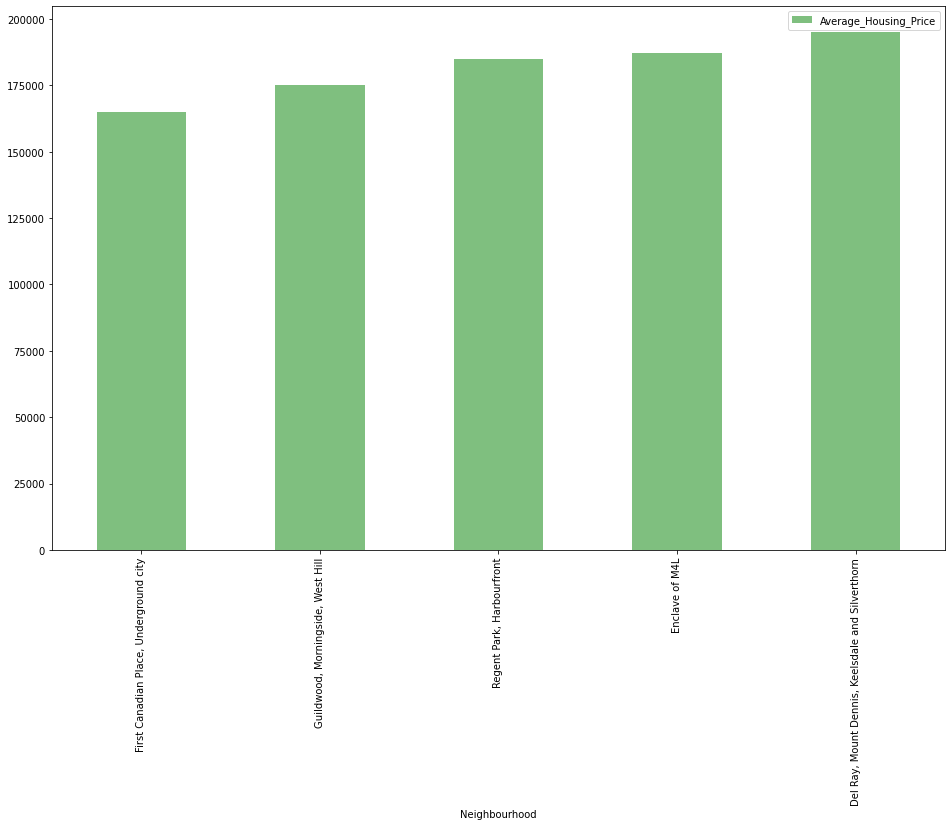

In [67]:
Top5_Cheapest_Neighborhoods = Avg_House_Price_Sorted[0:5]
Top5_Cheapest_Neighborhoods.plot(kind='bar',figsize=(16,10),color='green',alpha=0.5)

In [75]:
Top5_Cheapest_Neighborhoods

,Average_Housing_Price
Neighbourhood,
"First Canadian Place, Underground city",165000.0
"Guildwood, Morningside, West Hill",175000.0
"Regent Park, Harbourfront",185000.0
Enclave of M4L,187000.0
"Del Ray, Mount Dennis, Keelsdale and Silverthorn",195000.0


<br>

### Top 5 Most Expensive Neighborhoods

<AxesSubplot:xlabel='Neighbourhood'>

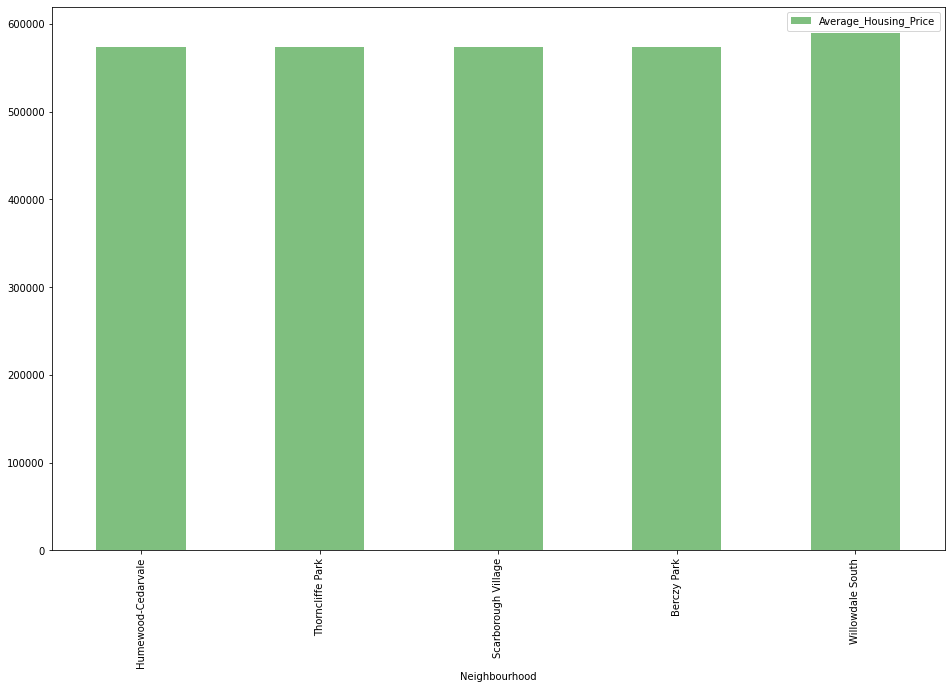

In [74]:
Top5_Expensive_Neighborhoods = Avg_House_Price_Sorted.tail()
Top5_Expensive_Neighborhoods.plot(kind='bar',figsize=(16,10),color='green',alpha=0.5)

In [76]:
Top5_Expensive_Neighborhoods

,Average_Housing_Price
Neighbourhood,
Humewood-Cedarvale,573900.0
Thorncliffe Park,573900.0
Scarborough Village,573900.0
Berczy Park,573900.0
Willowdale South,589900.0


### Sorting the Values to find Top 5 Neighborhoods for the Best/Worst Schools

In [81]:
School_Ratings_Sorted = Scarborough_school_ratings.sort_values(by=['Top School Rating'])
School_Ratings_Sorted.head()

,Top School Rating
Neighbourhood,
Glencairn,1
Lawrence Park,1
"Dorset Park, Wexford Heights, Scarborough Town Centre",1
"Cliffside, Cliffcrest, Scarborough Village West",1
Enclave of M4L,2


### Top 5 Neighborhoods with the Best Schools

<AxesSubplot:xlabel='Neighbourhood'>

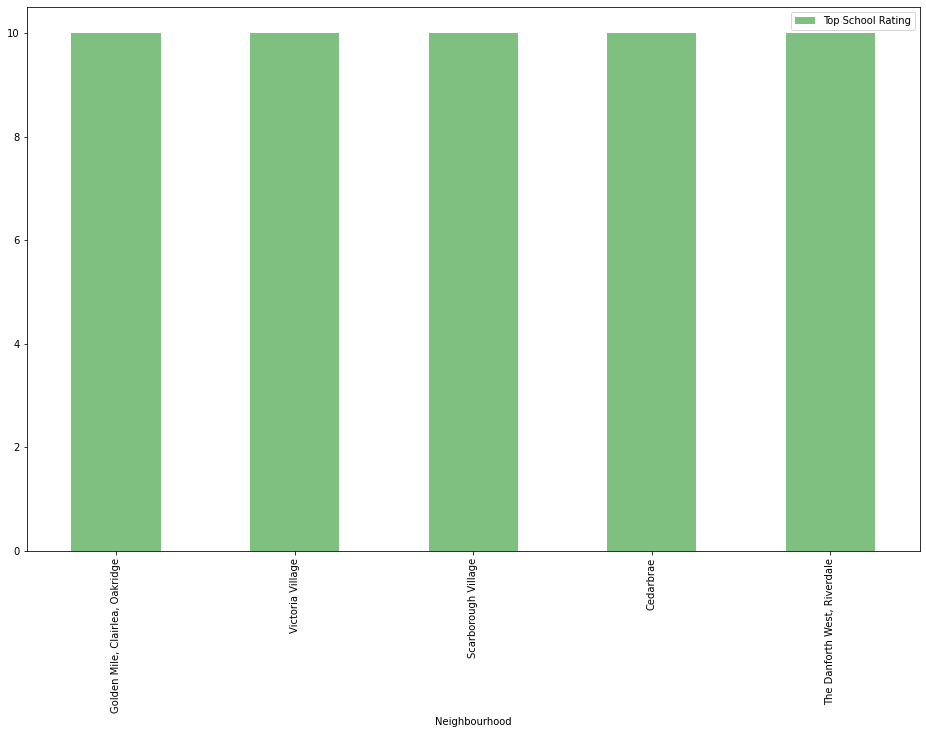

In [82]:
Top5_Best_Neighborhood_Schools = School_Ratings_Sorted.tail()
Top5_Best_Neighborhood_Schools.plot(kind='bar',figsize=(16,10),color='green',alpha=0.5)

In [83]:
Top5_Best_Neighborhood_Schools

,Top School Rating
Neighbourhood,
"Golden Mile, Clairlea, Oakridge",10
Victoria Village,10
Scarborough Village,10
Cedarbrae,10
"The Danforth West, Riverdale",10


### Worst 5 Neighborhoods with the Worst Rated Schools

<AxesSubplot:xlabel='Neighbourhood'>

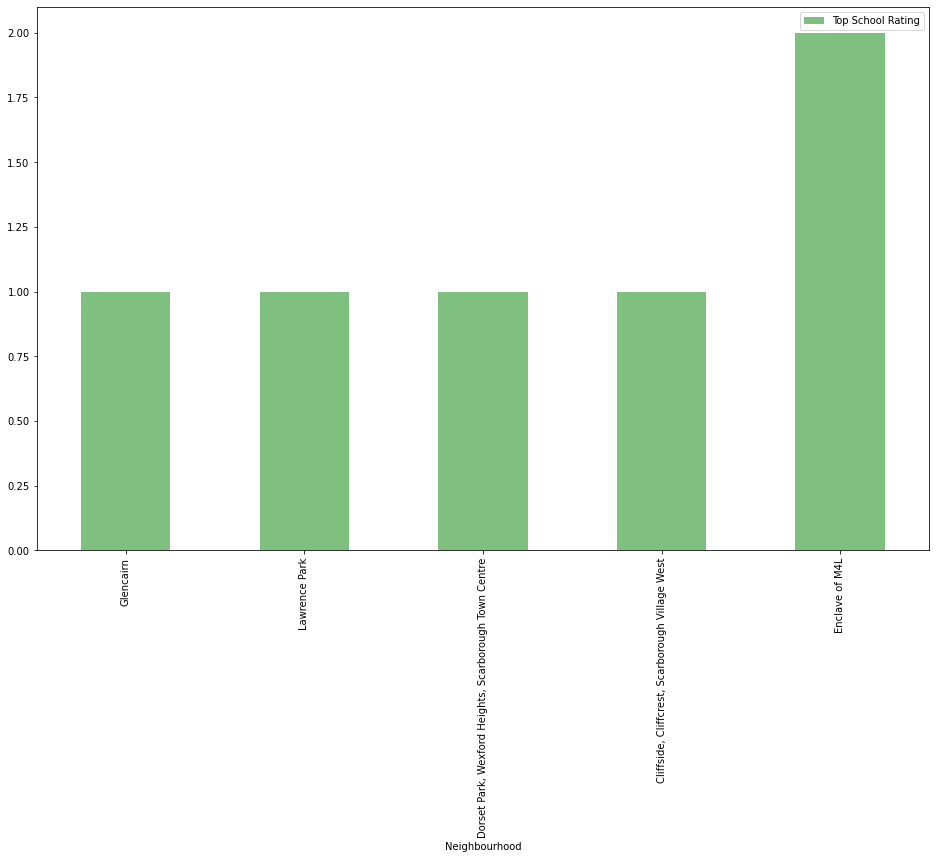

In [84]:
Worst5_Neighborhood_Schools = School_Ratings_Sorted.head()
Worst5_Neighborhood_Schools.plot(kind='bar',figsize=(16,10),color='green',alpha=0.5)

In [85]:
Worst5_Neighborhood_Schools

,Top School Rating
Neighbourhood,
Glencairn,1
Lawrence Park,1
"Dorset Park, Wexford Heights, Scarborough Town Centre",1
"Cliffside, Cliffcrest, Scarborough Village West",1
Enclave of M4L,2


### Conclusion

In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. 

Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.

## <center>---- END OF NOTEBOOK ---</center>